In [2]:
import duckdb
import os
import pandas as pd

In [3]:
CSV_PATH = os.path.abspath(os.path.join('..', 'data', 'raw', '311_service_requests.csv'))
DB_PATH = os.path.abspath(os.path.join('..', 'data', 'staging', 'data.duckdb'))

## CSV

The `311_service_requests.csv` file is 18 GB, so we have to read it in chunks.

In [4]:
chunk_size = 1000  # number of rows per chunk

In [5]:
# mapping between CSV columns and DuckDB columns
columns = {
  "Unique Key": "unique_key",
  "Created Date": "created_date",
  "Closed Date": "closed_date",
  "Agency": "agency",
  "Agency Name": "agency_name",
  "Complaint Type": "complaint_type",
  "Descriptor": "descriptor",
  "Location Type": "location_type",
  "Incident Zip": "incident_zip",
  "Incident Address": "incident_address",
  "City": "city",
  "Status": "status",
  "Borough": "borough",
  "X Coordinate (State Plane)": "x_coord",
  "Y Coordinate (State Plane)": "y_coord",
  "Latitude": "latitude",
  "Longitude": "longitude",
  "Location": "location"
}

In [39]:
conn = duckdb.connect(database=DB_PATH, read_only=False)

In [40]:
conn.execute("DROP TABLE IF EXISTS service_requests")

In [32]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html
chunk_iter = pd.read_csv(CSV_PATH, usecols=columns.keys(), chunksize=chunk_size, on_bad_lines='skip')

In [33]:
# df = chunk_iter.__next__()

In [34]:
df['City'].unique()

KeyError: 'City'

In [35]:
for i, df in enumerate(chunk_iter):
    df.rename(columns=columns, inplace=True)
    
    # TODO: to be removed 
    if i > 100: break
    # if i < 2300: continue
    # if i > 2330: break

    zips_to_drop = [
        '02061-0601',
        '06890-2101',
        '11725-9030',
        '11797-1016',
        '11804-9005',
        '12212-5368',
        '19154-3210',
        '55438-5908',
        '59901-3413',
        '61702-3517',
        '75007-1958',
        '77094-8911',
        '90060-0578',
        '94566-9057',
        '97076-0477',
        'DID N',
        'HARRISBURG',
        'NJ 07'
    ]
    
    mask = df['incident_zip'].astype(str).fillna('').str.contains('|'.join(zips_to_drop))
    indexes_to_drop = df[mask].index
    df.drop(indexes_to_drop, inplace=True)
    
    # df = df.apply(clean_row, axis=1)
    df['created_date'] = pd.to_datetime(df['created_date'], format='%m/%d/%Y %I:%M:%S %p')
    df['closed_date'] = pd.to_datetime(df['closed_date'], format='%m/%d/%Y %I:%M:%S %p')

    conn.execute(f"CREATE TABLE IF NOT EXISTS service_requests AS SELECT * FROM df")

    print(f"ingest chunk {i} into DuckDB")
    conn.execute(f"INSERT INTO service_requests SELECT * FROM df")

ingest chunk 0 into DuckDB
ingest chunk 1 into DuckDB
ingest chunk 2 into DuckDB
ingest chunk 3 into DuckDB
ingest chunk 4 into DuckDB
ingest chunk 5 into DuckDB
ingest chunk 6 into DuckDB
ingest chunk 7 into DuckDB
ingest chunk 8 into DuckDB
ingest chunk 9 into DuckDB
ingest chunk 10 into DuckDB
ingest chunk 11 into DuckDB
ingest chunk 12 into DuckDB
ingest chunk 13 into DuckDB
ingest chunk 14 into DuckDB
ingest chunk 15 into DuckDB
ingest chunk 16 into DuckDB
ingest chunk 17 into DuckDB
ingest chunk 18 into DuckDB
ingest chunk 19 into DuckDB
ingest chunk 20 into DuckDB
ingest chunk 21 into DuckDB
ingest chunk 22 into DuckDB
ingest chunk 23 into DuckDB
ingest chunk 24 into DuckDB
ingest chunk 25 into DuckDB
ingest chunk 26 into DuckDB
ingest chunk 27 into DuckDB
ingest chunk 28 into DuckDB
ingest chunk 29 into DuckDB
ingest chunk 30 into DuckDB
ingest chunk 31 into DuckDB
ingest chunk 32 into DuckDB
ingest chunk 33 into DuckDB
ingest chunk 34 into DuckDB
ingest chunk 35 into DuckDB
in

In [19]:
df.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'location_type', 'incident_zip',
       'incident_address', 'city', 'status', 'borough', 'x_coord', 'y_coord',
       'latitude', 'longitude', 'location'],
      dtype='object')

In [107]:
search_string = '59901-3413'

# If I do NOT know the column in which the problematic string appears
# Create a boolean DataFrame where each cell indicates if the search string is present
contains_string = df.map(lambda x: search_string in str(x))

# Reduce the boolean DataFrame to a Series indicating if the string is present in any column
rows_with_string = contains_string.any(axis=1)

result_df = df[rows_with_string]

print(f"Row index {result_df.index[0]} is problematic:\n")
print(result_df)

Row index 214061 is problematic:

        unique_key        created_date         closed_date agency  \
214061    23594481 2012-07-11 13:03:40 2012-07-27 01:06:26   DCWP   

                                         agency_name      complaint_type  \
214061  Department of Consumer and Worker Protection  Consumer Complaint   

           descriptor location_type incident_zip incident_address       city  \
214061  Debt Not Owed           NaN   59901-3413  1327 HIGHWAY 2W  KALISPELL   

        status      borough  x_coord  y_coord  latitude  longitude location  
214061  Closed  Unspecified      NaN      NaN       NaN        NaN      NaN  


In [45]:
# If I do know the column in which the problematic string appears

result_df = df[df['incident_zip'] == search_string]
print(result_df)
print(f"Drop these indexes {result_df.index}")

          unique_key        created_date         closed_date agency  \
16458336    43131584 2019-06-27 14:07:24 2019-06-28 10:03:29   DCWP   

                                           agency_name      complaint_type  \
16458336  Department of Consumer and Worker Protection  Consumer Complaint   

              descriptor location_type incident_zip  \
16458336  Process Server           NaN        DID N   

                     incident_address              city  status      borough  \
16458336  DID NOT DI DID NOT DISCLOSE  DID NOT DISCLOSE  Closed  Unspecified   

          x_coord  y_coord  latitude  longitude location  
16458336      NaN      NaN       NaN        NaN      NaN  
Drop these indexes Index([16458336], dtype='int64')


In [118]:
df.info('Incident Zip')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   complaint_date    285 non-null    datetime64[us]
 1   daily_complaints  285 non-null    int64         
 2   borough           284 non-null    object        
dtypes: datetime64[us](1), int64(1), object(1)
memory usage: 6.8+ KB


In [11]:
conn.sql("SELECT count(*) FROM service_requests")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      3502091 │
└──────────────┘

## DuckDB

In [9]:
duckdb.sql("SELECT 42").show()

┌───────┐
│  42   │
│ int32 │
├───────┤
│    42 │
└───────┘



In [23]:
conn.sql("SELECT count(*) FROM service_requests")

┌──────────────┐
│ count_star() │
│    int64     │
├──────────────┤
│      3471091 │
└──────────────┘

In [22]:
conn = duckdb.connect(database = DB_PATH, read_only = False)

In [112]:
conn.execute("SELECT * FROM service_requests WHERE borough = 'BRONX' AND status = 'Closed' LIMIT 10")
conn.fetchone()
# conn.fetchall()

(23320093,
 datetime.datetime(2012, 5, 29, 0, 0),
 datetime.datetime(2012, 6, 3, 0, 0),
 'HPD',
 'Department of Housing Preservation and Development',
 'PLUMBING',
 'WATER-SUPPLY',
 'RESIDENTIAL BUILDING',
 10452.0,
 '975 WALTON AVENUE',
 'BRONX',
 'Closed',
 'BRONX',
 1005589.0,
 241404.0,
 40.82924789920053,
 -73.92289242169471,
 '(40.829247899200524, -73.92289242169471)')

## Plots

In [114]:
import plotly
import plotly.express as px

In [115]:
query = f"""
    WITH daily_counts AS (
    SELECT
      date_trunc('day', created_date) AS complaint_date,
      borough,
      COUNT(*) AS daily_complaints
    FROM
      data.main.service_requests
    GROUP BY
      date_trunc('day', created_date),
      borough
    )
    SELECT
      complaint_date,
      daily_complaints,
      borough
    FROM
      daily_counts
    ORDER BY
      complaint_date,
      daily_complaints DESC;
    """
df = conn.execute(query).fetch_df()

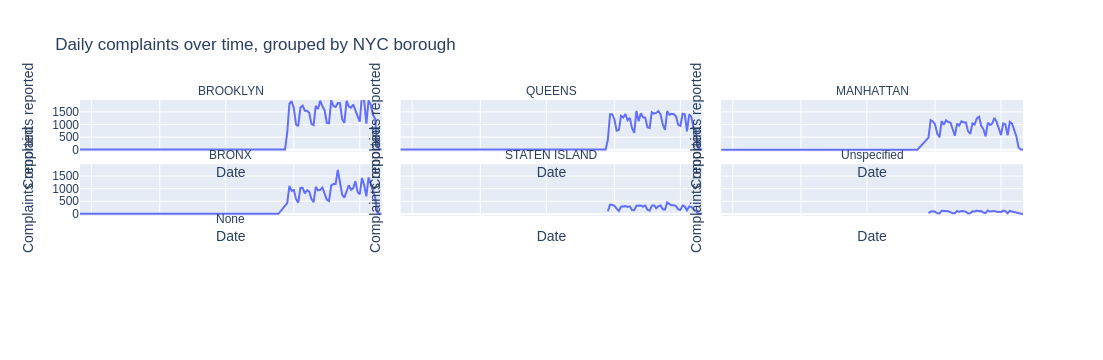

In [117]:
fig = px.line(df, x="complaint_date", y="daily_complaints", facet_col="borough",
      facet_col_wrap=3,
      title="Daily complaints over time, grouped by NYC borough"
)
# This changes each facet plot title from something like "borough=MANHATTAN" to just "MANHATTAN"
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.for_each_xaxis(lambda a: a.update(title="Date"))
fig.for_each_yaxis(lambda a: a.update(title="Complaints reported"))

# fig.show()

In [41]:
conn.close()